## Predicting the Chance of Winning a Game of League of Legends based on Champion Select

Introduction

The traditional game of League of Legends takes place on a map known as Summoner’s Rift, where there are three major lanes as well as a jungle comprised of monsters. There are two teams, blue team and red team, who’s bases exist on opposite sides of the non-symmetrical map. Minions run through each lane from both sides and the eventual goal of the game is to take down most of the towers of the enemy team and destroy the nest of their base, the “nexus.” However, there is a much simpler gamemode in league that many casual players really enjoy, known as ARAM; it instead takes place on a map that consists of only one lane, basically the mid lane of summoner’s rift. Both teams consisting of five random players are given random champions, and this is why the gamemode is called ARAM (all random, and all mid). Within this project, I will try and predict which side has a greater chance of winning a game of ARAM based on team composition. I’ll be training a model that will take into account not only thousands of past ARAM games, but also the current ARAM win rates of champions in patch 11.


To get access to the Riot Games API and replicate or add on to this tutorial, you have to first navigate to https://developer.riotgames.com/ and sign in with a Riot Games account. You will then have to fill out an application and should automatically get access to a development API key shortly afterwards.

Initially, I signed up for the Riot Games API as a college developer, and got my own unique API key to utilize. Thus, I was able to use the adapted cassiopeia python library of riot's league API to extract data.

In [1]:
import pandas as pd
import numpy as np
import random
import cassiopeia
import warnings
from sortedcontainers import SortedList
from cassiopeia.core import Match
from cassiopeia import Patch

warnings.filterwarnings('ignore')
# We have a list of champion names with respect to their key values, which signify a weight corresponding to their current winrate in patch 11.24
champions = pd.read_json("champInfo.json")
champions["key"] = champions["data"].apply(lambda x: x["key"])
champions["name"] = champions["data"].apply(lambda x: x["name"])
champions[["key","name"]]

,key,name
Aatrox,266,Aatrox
Ahri,103,Ahri
Akali,84,Akali
Alistar,12,Alistar
Amumu,32,Amumu
...,...,...
Zed,238,Zed
Ziggs,115,Ziggs
Zilean,26,Zilean
Zoe,142,Zoe


We then utilize a CountVectorizer to convert a list of champion names in champion select into a sparse vector where each element indicates whether the corresponding champion is present in the game. A positive value signifies that the champion is on blue team and a negative value that the champion is on red team. 

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(token_pattern = r"(?u)\b\w+\b") # This is to prevent removing one character key values
cv.fit(champions.key.values)

CountVectorizer(token_pattern='(?u)\\b\\w+\\b')

In [3]:
# Export the CV as a pickle file for later use
import pickle
pickle.dump(cv, open("cv.p", "wb"))

## Pull thousands of matches

We utilize get requests to retrieve the match history of a certain starter summoner by name, and for each ARAM match within this match history, we run another get request using the riot API to gather more specifics about this match through its match ID. We then repeat this process with extended summoners/players (as we have access to 9 other players within each match), until we eventually hit the number of matches we desire in our dataset for training (5000 in our case). Please take a look at https://github.com/meraki-analytics/cassiopeia/tree/master/examples and https://cassiopeia.readthedocs.io/en/latest/ to understand more about how the Riot Games API functions; it's quite neat!

In [4]:
cassiopeia.set_riot_api_key('RGAPI-7bfd94d1-757c-46da-a1ee-5f94298c0d8f') # This unique API key expires on 12/21/2021. Please generate another API key on the riot games dev website if you wish to re-run the code for your own analysis.
firstSummoner = cassiopeia.get_summoner(name='mattgu16', region='NA')
currPatch = Patch.from_str('11.24', region='NA')

# create a sorted list for player ID's (we start with the initial summoner name, my friend Matt Gu who really enjoys playing ARAM) 
unprocessedSummoners = SortedList(['mattgu16']) # Essentially, we have a huge tree of connected players starting with one player. From that one players game, we have access to 9 other players, and from each of those summoners' games, we have access to games of 9 other summoners. Thus, we essentially have thousands and thousands of branching matches.
processedSummoners = SortedList()
unprocessedMatches = SortedList()
processedMatches = SortedList()

# number of random matches pulled for our training data
num_matches = 250

# Finally crawl through collect match id's
while unprocessedSummoners and len(processedMatches) < num_matches:
    # Get a random summoner from our list of unpulled summoners and pull their match history
    newSummonerName = random.choice(unprocessedSummoners)
    newSummoner = cassiopeia.get_summoner(name=newSummonerName, region='NA')
    matches = newSummoner.match_history

    for match in matches:
        if (not isinstance(match.id, int)):
            unprocessedMatches.update([match.id])
    
    # After we pull the match id's from the summoner we 
    unprocessedSummoners.remove(newSummonerName)
    processedSummoners.add(newSummonerName)

    while unprocessedMatches and len(processedMatches) < num_matches:
        # Get a random match from our list of matches
        newMatchID = random.choice(unprocessedMatches)
        newMatch = Match(id=newMatchID, region='NA')
        for player in newMatch.participants:
            if player.summoner.name not in processedSummoners and player.summoner.name not in unprocessedSummoners:
                unprocessedSummoners.add(player.summoner.name)
        # The above lines will trigger the match to load its data by iterating over all the participants.
        # If you have a database in your datapipeline, the match will automatically be stored in it.
        unprocessedMatches.remove(newMatchID)
        processedMatches.add(newMatchID)

Making call: https://cdn.merakianalytics.com/riot/lol/resources/patches.json
Making call: https://na1.api.riotgames.com/lol/summoner/v4/summoners/by-name/mattgu16
Making call: https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/RQ42LuhfbXQt8Ar-HgZG5NhjB-U3J5-9cZEcZYQVJ9sGMjgJ1Tg-0oGD6dJFgebtZzJNbT1eLkRxYw/ids?beginIndex=0&endIndex=100
Making call: https://americas.api.riotgames.com/lol/match/v5/matches/NA1_4144470775
Making call: https://americas.api.riotgames.com/lol/match/v5/matches/NA1_4138972721
Making call: https://americas.api.riotgames.com/lol/match/v5/matches/NA1_4145349793
Making call: https://americas.api.riotgames.com/lol/match/v5/matches/NA1_4140718487
Making call: https://americas.api.riotgames.com/lol/match/v5/matches/NA1_4138988652
Making call: https://americas.api.riotgames.com/lol/match/v5/matches/NA1_4138758589
Making call: https://americas.api.riotgames.com/lol/match/v5/matches/NA1_4142796080
Making call: https://americas.api.riotgames.com/lol/match/v5/m

In [5]:
 # Save into pickle
import pickle
pickle.dump(processedMatches, open("matchID.p", "wb" ))
processedMatches # A list of all the match ID's we pulled to later analyze

SortedList(['NA1_4129768876', 'NA1_4130761673', 'NA1_4131567325', 'NA1_4131612566', 'NA1_4131960410', 'NA1_4131970787', 'NA1_4134124208', 'NA1_4135706821', 'NA1_4135725349', 'NA1_4135859285', 'NA1_4135883861', 'NA1_4135892358', 'NA1_4135906442', 'NA1_4135915139', 'NA1_4135930633', 'NA1_4135943088', 'NA1_4136071678', 'NA1_4136124126', 'NA1_4136137723', 'NA1_4136447414', 'NA1_4136493929', 'NA1_4136921711', 'NA1_4136948909', 'NA1_4136975355', 'NA1_4136982367', 'NA1_4137097160', 'NA1_4137169437', 'NA1_4137493870', 'NA1_4137620071', 'NA1_4138708812', 'NA1_4138734952', 'NA1_4138758589', 'NA1_4138786476', 'NA1_4138914856', 'NA1_4138936200', 'NA1_4138967297', 'NA1_4138972721', 'NA1_4138988652', 'NA1_4139001158', 'NA1_4139054113', 'NA1_4139062747', 'NA1_4139595514', 'NA1_4139659327', 'NA1_4139741765', 'NA1_4139872010', 'NA1_4139896154', 'NA1_4139913580', 'NA1_4139932604', 'NA1_4140024947', 'NA1_4140045550', 'NA1_4140091054', 'NA1_4140280634', 'NA1_4140718487', 'NA1_4140747363', 'NA1_4140871463'

Now that we have a list of all the match ID's we wanted, we start our training process. We iterate through all the matches, figure out what champions were on blue and red side during that match, and pass in the resultant target variable that shows which team won. We create a pandas dataframe with all this information and store it as a pickle file for later use.

In [6]:
# open pulled match id's
match_ids = pickle.load(open("matchID.p", "rb"))

# create new dataframe
df = pd.DataFrame(columns=["MatchID","BlueWin"] + [(champions.index)[champions.key == str(i)][0] for i in cv.get_feature_names()])

for ids in match_ids:
    
    currMatch = Match(id=ids, region="NA") # get match object
    participants = currMatch.participants  # get champions in the match
    result = int(currMatch.blue_team.win)  # get result of the match

    blue_team = []
    red_team = []
    for player in participants:
        if player.team.side.name == 'blue': 
            blue_team.append(str(player.champion.id))
        else:
            red_team.append(str(player.champion.id))

            
    # to get +1 for blue team and -1 for red team, we minus the two vectors        
    X = (cv.transform([",".join(blue_team)]) - cv.transform([",".join(red_team)])).toarray()
    
    # Join ID, result, and previous match vector (as a single row)
    row = np.append(np.array([ids,result]),X)
    
    # Add to the dataframe
    df.loc[len(df)] = row
    

# Reset Index to the matches
pickle.dump(df ,open("df.p", "wb"))

Making call: https://ddragon.leagueoflegends.com/api/versions.json


After training the model on thousands of ARAM games in addition to the provided winrates of champions (the individual weights of each champion will be tuned from the initial winrate as we analyze games, as winrate is definitely not everything and can be very misleading), we will then test the accuracy of this model by running it back on the provided dataset of sample ARAM games. The beauty of league of legends is that each game feels pretty random; although team composition (champions chosen in the pre-game lobby) do make a big difference in the end result, there's so much that could potentially occur that even if one comp is much stronger than the other, most games are close to being coinflips. Thus, I don't expect this algorithm to be very accurate but any accuracy above 55% is honestly still impressive.

Furthermore, after the model was fully trained, I analyzed mirror matchups on both sides with the algorithm and found that blue side typically had a higher expected chance of winning compared to red side. This does make sense as the map is not symmetrical, meaning that vision and controls happen to be slightly more beneficial to blue side. Thus, I modified the algorithm by adding a slight fixed boost to blue side's chance of winning.

As for the algorithms I utilized to train this model, I chose logistic regression, ridge regression, a SVM, and a decision tree. Since the dependent variable is binary (either blue team won or not), I decided that it was best to use logistic regression for the further analysis, but I still checked the accuracy of the other models.
If you wish to learn more about how logistic regression works, please take a look at this link: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [7]:
import pickle
import numpy as np
import pandas as pd
import os
import sys
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LogisticRegressionCV

# I have pulled the initial win rates of champions in patch 11.24 in ARAM, but I will be fine-tuning these through the thousands of games analyzed. I will then convert the
# raw rating of each champion to a number between 0-100 representing the champion's "strength" in ARAM games (not necessarily winrate) through the following logistic function.
def score(x,a=1):
    return (1/(1+np.exp(-a*(x))))*100

# Get dataframe
df = pickle.load(open(os.path.join(sys.path[0], "df.p"), "rb"))
df.set_index('MatchID',inplace=True)


# Split into features vs target
X = df.drop("BlueWin",axis=1)
y = df.BlueWin.astype('int')

# Get train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10)

# Set random seed
np.random.seed()

# Logistic Regression CV
lr = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, y_train)

# Ridge Regression CV
rc = RidgeClassifierCV(cv=5).fit(X_train, y_train)

# Parameters for Max Depth for SVM
parameters_svm = {'C':np.logspace(-3,3,5)}
svm = GridSearchCV(LinearSVC(), parameters_svm, n_jobs=-1).fit(X_train,y_train).best_estimator_


# Parameters for Max Depth for Decision Tree
parameters_dt = {'max_depth':range(20,100,5)}
dt = GridSearchCV(DecisionTreeClassifier(), parameters_dt, n_jobs=-1).fit(X_train,y_train).best_estimator_

classifiers = [lr,rc,svm,dt]
algos = ["Logistic Regression","Ridge Regression","SVM","Decision Tree"]
for i in range(4):
    print("{}: train accuracy was: {:.4f} and test accuracy was {:.4f}".format(algos[i],accuracy_score(y_train,classifiers[i].predict(X_train)),accuracy_score(y_test,classifiers[i].predict(X_test))))

# pickle fitted logistic regression object
pickle.dump(lr, open("/home/cs/cmsc320/arman-b.github.io/logistic_regression.p", "wb"))

# Create champion ranking list from the coefficients
rankings = pd.DataFrame({'Champion':X_train.columns,'Score':score(lr.coef_.flatten(),7)}).sort_values('Score',ascending=False).reset_index(drop=True)

rankings.Score = rankings.Score.round(5)
rankings.reset_index(inplace=True)
rankings.columns = ["Rank","Champion","Score"]
rankings.Rank += 1 # Rank is 1-indexed

pickle.dump(rankings ,open( "/home/cs/cmsc320/arman-b.github.io/scores.p", "wb" ))
rankings

/home/cs/cmsc320/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/cs/cmsc320/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/cs/cmsc320/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Logistic Regression: train accuracy was: 0.8250 and test accuracy was 0.4000
Ridge Regression: train accuracy was: 0.9000 and test accuracy was 0.4000
SVM: train accuracy was: 0.8417 and test accuracy was 0.5000
Decision Tree: train accuracy was: 1.0000 and test accuracy was 0.4000


,Rank,Champion,Score
0,1,Kayle,84.51117
1,2,Shaco,83.04658
2,3,Zyra,78.16903
3,4,LeeSin,77.70839
4,5,Karthus,77.64757
...,...,...,...
140,141,Evelynn,23.49829
141,142,Nidalee,20.01785
142,143,KogMaw,19.84898
143,144,Leblanc,12.46495


As we can see above, due to the really random nature of League games, our accuracy was pretty low for all models. Furthermore, we only predicted based on champion select, so there are so many features we didn't account for, such as player rank, runes, and builds.  As for champion rankings, we see that the adjusted score seems to be generally pretty stable across the board, although there are definitely some champions with greater chances of winning than others.

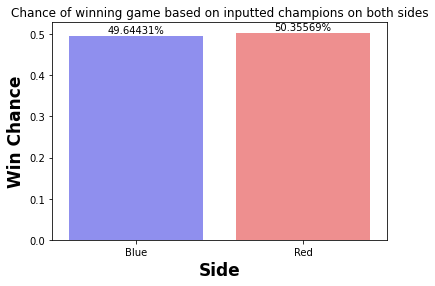

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

champions = pd.read_json("/home/cs/cmsc320/arman-b.github.io/champInfo.json")
countvectorizer = pickle.load(open(os.path.join(sys.path[0], "cv.p"), "rb" ))
logisticregressor = pickle.load(open(os.path.join(sys.path[0], "logistic_regression.p"), "rb"))
scores = pickle.load(open(os.path.join(sys.path[0], "scores.p"), "rb"))

blueComp = ["Draven", "Ahri", "Ryze", "Teemo", "Blitzcrank"]
redComp = ["Trundle", "Irelia", "Katarina", "Vayne", "Ashe"]  #Modify these two arrays to see the chance of winning your own game based on team composition!

result = logisticregressor.predict_proba((countvectorizer.transform([",".join(blueComp)]) - countvectorizer.transform([",".join(redComp)])).toarray())[0]

ax = sns.barplot(x=['Blue', 'Red'], y=[result[0], result[1]], alpha=0.5, palette=["Blue", "Red"])
plt.xlabel('Side', fontsize=17, fontweight='bold')
plt.ylabel('Win Chance', fontsize=17, fontweight='bold')
plt.title('Chance of winning game based on inputted champions on both sides') 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height +.007,
            '{:1.5f}%'.format(100*height),
            ha="center") 
plt.show()

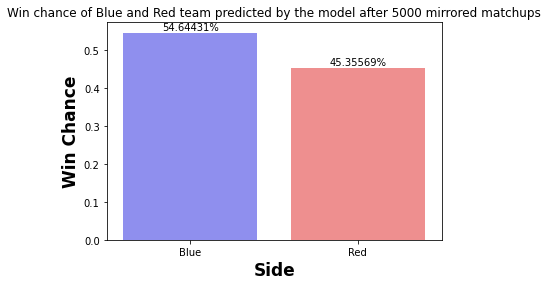

In [13]:
totalBlue = 0
totalRed = 0
for i in range(5000):
    teamComp = champions.sample(5)
    result = logisticregressor.predict_proba((countvectorizer.transform([",".join(teamComp)]) - countvectorizer.transform([",".join(teamComp)])).toarray())[0]
    totalBlue += result[0] + 0.05
    totalRed += result[1] - 0.05
    
# Plot the results and label the graph
ax = sns.barplot(x=['Blue', 'Red'], y=[totalBlue/5000, totalRed/5000], alpha=0.5, palette=["Blue", "Red"])
plt.xlabel('Side', fontsize=17, fontweight='bold')
plt.ylabel('Win Chance', fontsize=17, fontweight='bold')
plt.title('Win chance of Blue and Red team predicted by the model after 5000 mirrored matchups') 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height +.007,
            '{:1.5f}%'.format(100*height),
            ha="center") 
plt.show()

As we can see, when the champions on both sides are mirrored, the blue team seems to have a slightly higher chance of winning, which leads us to believe that there is an inherent bias towards blue side.

As for future improvements to this project, I could potentially make a win predictor for Summoner’s Rift one day. It would be a lot more complicated and less accurate as there are not only many more factors (such as objectives, dragons, and ganking) but also a lot of skewed lane matchups, meaning we have to consider team synergy as well as counter champions. It would also be cool to analyze everyone’s ranks on both teams to make the prediction even more accurate. I’m currently a diamond adc main (draven one trick) and really enjoy playing ranked summoner’s rift, so I might look into doing so in the future.

Thank you so much for taking the time to read this and I hope you found it interesting!